In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class KaggleMNIST(Dataset):
    """ Kaggle's MNIST dataset. """
    def __init__(self, csv_file, transform=None):
        """
        Args: 
            csv_file (string): Path to CSV file with image pixel data
            transform (callable, optional): Optional transform applied to the sample
        """
        self.pixel_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.pixel_frame)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.pixel_frame.iloc[index, 1:].to_numpy(dtype='float64').reshape(1, -1)
        label = self.pixel_frame.iloc[index, 0]
        if self.transform:
            image = self.transform(image)

        return {'image':image, 'label':label}
    
class normalize(object):
    """
    Normalize image vectors from Kaggle's MNIST dataset
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, image):
        return (image - self.mean) / self.std
    

In [3]:
tfs = transforms.Compose([transforms.ToTensor(), 
                          normalize(0.5, 0.5)])

data = KaggleMNIST('data/train.csv', transform=tfs)
lengths = (33600, 8400)
trainset, validset = torch.utils.data.random_split(data, lengths)
testset = KaggleMNIST('data/test.csv')

In [4]:
trainload = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=4, shuffle=True)
validload = torch.utils.data.DataLoader(validset, batch_size=64, num_workers=4, shuffle=True)
testload = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=4, shuffle=True)

In [5]:
sample = iter(trainload).next()
images = sample['image']
len(trainload), images.shape

(525, torch.Size([64, 1, 1, 784]))

In [6]:
images.view(images.shape[0], -1).shape

torch.Size([64, 784])

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        self.do = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.do(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
        

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = Network()
criterion = nn.NLLLoss()
opt = optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

In [15]:
valid_loss = []
train_loss = []
accuracy   = []

model.to(device)

for e in range(epochs):
    running_vl = 0
    running_tl = 0
    running_ac = 0
    
    # back propogation
    for sample in trainload:
        images = sample['image']
        labels = sample['label']
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)
        
        opt.zero_grad()
        logps = model.forward(images.float())
        t_loss = criterion(logps, labels)
        t_loss.backward()
        opt.step()
        
        running_tl += t_loss.item()
        
    # validation pass
    model.eval()
    with torch.no_grad():
        for sample in validload:
            images = sample['image'].to(device)
            labels = sample['label'].to(device)
            images = images.view(images.shape[0], -1)

            logps = model(images.float())
            preds = torch.argmax(logps, dim=1)
            v_loss = criterion(logps, labels)
            running_ac += (preds == labels).cpu().numpy().mean()
            running_vl += v_loss.item()
    model.train()
    
    # compute metrics for epoch
    train_loss.append(running_tl/len(trainload))
    valid_loss.append(running_vl/len(validload))
    accuracy.append(running_ac/len(validload))

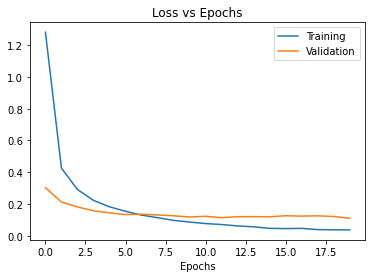

In [16]:
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.legend()
plt.show()

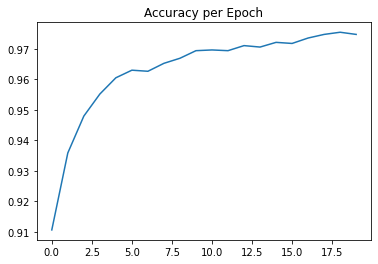

In [19]:
plt.title('Accuracy per Epoch')
plt.plot(accuracy)

In [23]:
testdata = pd.read_csv('data/test.csv').to_numpy(dtype='float64')
testdata = torch.from_numpy(testdata)

torch.float64

In [41]:
logps = model(testdata.float().to(device))
logps = logps.to('cpu');

In [42]:
predictions = torch.argmax(logps, dim=1).numpy()

In [45]:
sub_df = pd.DataFrame({
    'ImageId':range(1, len(predictions) + 1),
    'Label':predictions
})

In [47]:
sub_df.to_csv('submission.csv', index=False)